# Analyzing results for the `boolq` dataset

Assuming you've run the experiments for the boolq dataset, we can now go through
the process of collecting and summarizing the results.

In [114]:
import pathlib
import json
import pandas as pd

# the path to the output results for boolq
output_path = pathlib.Path("../output/boolq")


def collect_results(metadata_path: pathlib.Path) -> dict:
    """Collect the metadata and report together."""
    with open(metadata_path, "r", encoding="utf8") as fp:
        data = json.load(fp)
    with open(metadata_path.parent / "report.json", "r", encoding="utf8") as fp:
        data = data | json.load(fp)
    return data


all_results = []
for metadata_path in output_path.rglob("metadata.json"):
    all_results.append(collect_results(metadata_path))
df = pd.DataFrame(all_results)

# train_split and train_size mean the same thing, but its much easier working with integers for plotting
df["train_size"] = (
    df["train_split"].str.split("-").apply(lambda pair: pair[1]).astype(int)
)
df.head()

,train_split,dataset_name,dataset_seed,model_path,max_length,learning_rate,batch_size,algorithm,setfit_num_iterations,setfit_num_epochs,0,1,accuracy,macro avg,weighted avg,fine_tuning_gradient_accumulation_steps,fine_tuning_max_steps,fine_tuning_problem_type,train_size
0,train-100,boolq,1379487842,bert-base-uncased,128,0.00001,4,setfit,20.0,1.0,"{'precision': 0.3708791208791209, 'recall': 0....","{'precision': 0.6171383647798742, 'recall': 0....",0.5275,"{'precision': 0.4940087428294975, 'recall': 0....","{'precision': 0.5239292409634391, 'recall': 0....",NaN,NaN,NaN,100
1,train-100,boolq,1379487842,bert-base-uncased,128,0.00001,4,fine-tuning,NaN,NaN,"{'precision': 0.33583489681050654, 'recall': 0...","{'precision': 0.6059986366734833, 'recall': 0....",0.5340,"{'precision': 0.4709167667419949, 'recall': 0....","{'precision': 0.5037416611353466, 'recall': 0....",1.0,250.0,single_label_classification,100
2,train-25,boolq,1379487842,bert-base-uncased,128,0.00001,4,setfit,20.0,1.0,"{'precision': 0.38596491228070173, 'recall': 0...","{'precision': 0.6233603997501561, 'recall': 0....",0.5760,"{'precision': 0.5046626560154289, 'recall': 0....","{'precision': 0.5335062077429676, 'recall': 0....",NaN,NaN,NaN,25
3,train-25,boolq,1379487842,bert-base-uncased,128,0.00001,4,fine-tuning,NaN,NaN,"{'precision': 0.3885350318471338, 'recall': 0....","{'precision': 0.6260932944606414, 'recall': 0....",0.5515,"{'precision': 0.5073141631538876, 'recall': 0....","{'precision': 0.5361774920614287, 'recall': 0....",1.0,250.0,single_label_classification,25
4,train-50,boolq,1379487842,bert-base-uncased,128,0.00001,4,setfit,20.0,1.0,"{'precision': 0.3816793893129771, 'recall': 0....","{'precision': 0.6222775357809583, 'recall': 0....",0.5750,"{'precision': 0.5019784625469678, 'recall': 0....","{'precision': 0.5312111373428274, 'recall': 0....",NaN,NaN,NaN,50


## Extracting dictionary results

Now that we have our data, we want to do some processing with it. Note that macro avg and weighted avg scores are actually dictionaries. We can split them into individual columns as follows:

In [115]:
for column in ["macro avg", "weighted avg"]:
    df = pd.concat([df, pd.json_normalize(df[column]).add_prefix(f"{column} ")], axis=1)
df.head()

,train_split,dataset_name,dataset_seed,model_path,max_length,learning_rate,batch_size,algorithm,setfit_num_iterations,setfit_num_epochs,...,fine_tuning_problem_type,train_size,macro avg precision,macro avg recall,macro avg f1-score,macro avg support,weighted avg precision,weighted avg recall,weighted avg f1-score,weighted avg support
0,train-100,boolq,1379487842,bert-base-uncased,128,0.00001,4,setfit,20.0,1.0,...,NaN,100,0.494009,0.494104,0.493945,2000,0.523929,0.5275,0.525611,2000
1,train-100,boolq,1379487842,bert-base-uncased,128,0.00001,4,fine-tuning,NaN,NaN,...,single_label_classification,100,0.470917,0.475832,0.466804,2000,0.503742,0.5340,0.512800,2000
2,train-25,boolq,1379487842,bert-base-uncased,128,0.00001,4,setfit,20.0,1.0,...,NaN,25,0.504663,0.503165,0.484132,2000,0.533506,0.5760,0.537032,2000
3,train-25,boolq,1379487842,bert-base-uncased,128,0.00001,4,fine-tuning,NaN,NaN,...,single_label_classification,25,0.507314,0.506697,0.504663,2000,0.536177,0.5515,0.541676,2000
4,train-50,boolq,1379487842,bert-base-uncased,128,0.00001,4,setfit,20.0,1.0,...,NaN,50,0.501978,0.501328,0.481312,2000,0.531211,0.5750,0.534879,2000


## Basic aggregation

Let's say we're interested in accuracy, weighted avg f1-score, and macro avg f1-score.
We can gather these results as follows:

In [116]:
target_columns = ["accuracy", "weighted avg f1-score", "macro avg f1-score"]
base_groupby_columns = ["dataset_name", "train_size", "algorithm"]
df.groupby(base_groupby_columns)[target_columns].agg(["mean", "std"])

accuracy           weighted avg f1-score   
                                         mean       std                  mean   
dataset_name train_size algorithm                                               
boolq        25         fine-tuning  0.565333  0.017495              0.541719  \
                        setfit       0.584000  0.010583              0.533952   
             50         fine-tuning  0.545667  0.014092              0.540225   
                        setfit       0.566833  0.014580              0.544938   
             100        fine-tuning  0.574667  0.035346              0.518939   
                        setfit       0.556667  0.025614              0.536471   

                                              macro avg f1-score            
                                          std               mean       std  
dataset_name train_size algorithm                                           
boolq        25         fine-tuning  0.017124           0.501214  0.031655  
                        setfit       0.003481           0.478429  0.009921  
             50         fine-tuning  0.012927           0.508082  0.013700  
                        setfit       0.012232           0.503108  0.019453  
             100        fine-tuning  0.009453           0.461097  0.013664  
                        setfit       0.015707           0.495859  0.015366

We can also make the results look a little nicer and multiply through by 100 to get scores:

In [117]:
(df.groupby(base_groupby_columns)[target_columns].agg(["mean", "std"]) * 100).round(1)

accuracy      weighted avg f1-score        
                                        mean  std                  mean  std   
dataset_name train_size algorithm                                              
boolq        25         fine-tuning     56.5  1.7                  54.2  1.7  \
                        setfit          58.4  1.1                  53.4  0.3   
             50         fine-tuning     54.6  1.4                  54.0  1.3   
                        setfit          56.7  1.5                  54.5  1.2   
             100        fine-tuning     57.5  3.5                  51.9  0.9   
                        setfit          55.7  2.6                  53.6  1.6   

                                    macro avg f1-score       
                                                  mean  std  
dataset_name train_size algorithm                            
boolq        25         fine-tuning               50.1  3.2  
                        setfit                    47.8  1.0  
             50         fine-tuning               50.8  1.4  
                        setfit                    50.3  1.9  
             100        fine-tuning               46.1  1.4  
                        setfit                    49.6  1.5

## Algorithm-specific grouping

Note of course that I'm assuming most of the columns use only a single value and therefore don't need to be grouped on.
If for example you use multiple different values of `model_path`, you'll need to add `model_path` to the `groupby` above.
If you start to use parameters specific to an algorithm, it's easiest to just split the dataframe by algorithm and process each segment separately.
For example:

In [118]:
setfit_df = df.loc[df["algorithm"].eq("setfit")].astype(
    {"setfit_num_epochs": int, "setfit_num_iterations": int}
)
setfit_df = (
    setfit_df.groupby(
        base_groupby_columns + ["setfit_num_iterations", "setfit_num_epochs"]
    )[target_columns].agg(["mean", "std"])
    * 100
).reset_index()
fine_tuning_df = df.loc[df["algorithm"].eq("fine-tuning")].astype(
    {"fine_tuning_gradient_accumulation_steps": int, "fine_tuning_max_steps": int}
)
fine_tuning_df = (
    fine_tuning_df.groupby(
        base_groupby_columns
        + ["fine_tuning_gradient_accumulation_steps", "fine_tuning_max_steps"]
    )[target_columns].agg(["mean", "std"])
    * 100
).reset_index()

In [119]:
fine_tuning_df

dataset_name train_size    algorithm   
                                         
0        boolq         25  fine-tuning  \
1        boolq         50  fine-tuning   
2        boolq        100  fine-tuning   

  fine_tuning_gradient_accumulation_steps fine_tuning_max_steps   accuracy   
                                                                      mean   
0                                       1                   250  56.533333  \
1                                       1                   250  54.566667   
2                                       1                   250  57.466667   

            weighted avg f1-score           macro avg f1-score            
        std                  mean       std               mean       std  
0  1.749524             54.171867  1.712399          50.121358  3.165493  
1  1.409196             54.022472  1.292716          50.808182  1.369982  
2  3.534591             51.893926  0.945348          46.109717  1.366435

## Plotting

Finally, we can move on to plotting our results.

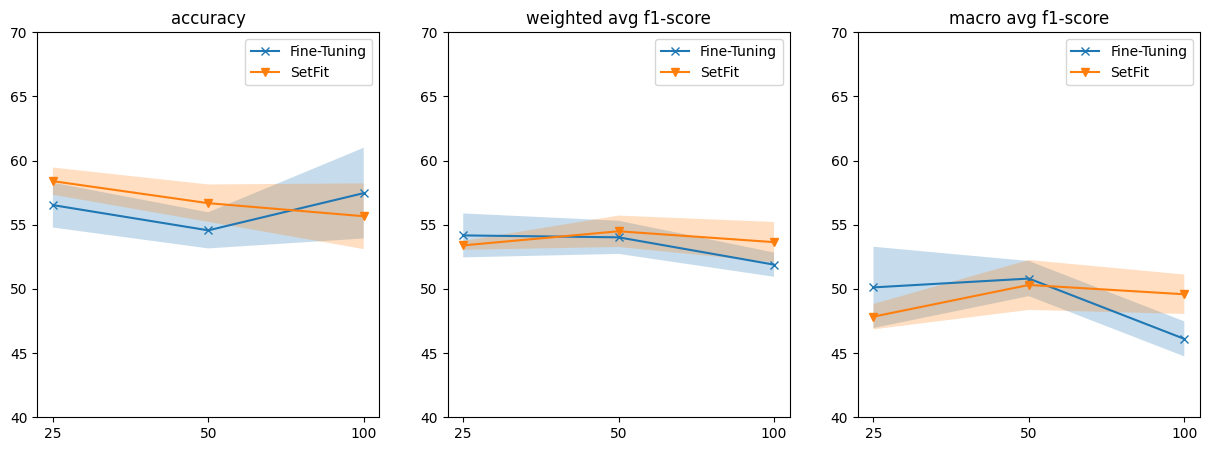

In [120]:
import matplotlib.pyplot as plt


def plot_column(
    ax: plt.Axes,
    df: pd.DataFrame,
    col_name: str,
    label: str,
    plot_kwargs: dict,
    fill_between_kwargs: dict,
):
    """Plot a target column with fill for a specific algorithm.

    :param algorithm_df: The specific dataframe to plot for. E.g., `fine_tuning_df`.
    :param plot_kwargs: Key-word arguments for `plot`
    :param fill_between_kwargs: Key-word arguments for `fill_between`
    """
    mean = df[(col_name, "mean")]
    std = df[(col_name, "std")]
    ax.fill_between(
        df["train_size"], mean - std, mean + std, alpha=0.25, **fill_between_kwargs
    )
    ax.plot(df["train_size"], mean, label=label, **plot_kwargs)


fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
for idx, col_name in enumerate(target_columns):
    ax: plt.Axes = axes[idx]
    plot_column(ax, fine_tuning_df, col_name, "Fine-Tuning", {"marker": "x"}, {})
    plot_column(ax, setfit_df, col_name, "SetFit", {"marker": "v"}, {})
    ax.set_ylim(40, 70)

    ax.set_xscale("log", base=2)
    ax.set_title(col_name)
    ax.set_xticks(fine_tuning_df["train_size"].unique())
    ax.set_xticklabels(fine_tuning_df["train_size"].unique())
    ax.legend()